In [1]:
import os
import json
import torch
import numpy as np
import cv2, zlib, base64
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image
import zipfile
from tempfile import TemporaryDirectory
import time

In [2]:
zip_file_img = 'img.zip'
output_folder_img = 'jupyter'
with zipfile.ZipFile(zip_file_img, 'r') as zip_ref:
    zip_ref.extractall(output_folder_img)
zip_file_ann = 'ann.zip'
output_folder_ann = 'jupyter'
with zipfile.ZipFile(zip_file_ann, 'r') as zip_ref:
    zip_ref.extractall(output_folder_ann)

In [3]:
for file_name in os.listdir('img'):
    mask_path = os.path.join('ann', file_name + '.json')
    with open(mask_path, 'r', encoding='utf-8') as annotReader:
        labels = json.loads(annotReader.read())
    if len(labels['objects']) == 0:
        os.remove(os.path.join('img', file_name))
        os.remove(mask_path)
        print(f"Удалено изображение '{file_name}' и его json файл")      

In [101]:
folder_name = 'img'
ann = 'ann'

transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Resize((720, 720))
    ])

def base64_2_mask(s):
    z = zlib.decompress(base64.b64decode(s))
    n = np.frombuffer(z, np.uint8)
    mask = cv2.imdecode(n, cv2.IMREAD_UNCHANGED)[:, :, 3].astype(bool)
    return mask
    
class CustomDataset(Dataset):
    def __init__(self, folder_name, ann, transforms=None):
        self.folder_name = folder_name
        self.ann = ann
        self.transform = transform
        self.images = os.listdir(folder_name)
        
    def __len__(self):
        return len(self.images)

    def get_mask(self, labels):
        if len(labels["objects"]) == 0:
            empty_mask = np.zeros((labels['size']['height'], labels['size']['width']), dtype=np.float32)
            empty_mask = self.transform(empty_mask)
            return empty_mask
        for i in range(len(labels['objects'])):
            mask = np.zeros((labels['size']['height'], labels['size']['width']), dtype=np.float32)
            bitmap = labels['objects'][i]['bitmap']['data']
            start_point = labels['objects'][i]['bitmap']['origin']
            mask_small = base64_2_mask(bitmap)
            mask[start_point[1] : start_point[1] + mask_small.shape[0],
                 start_point[0] : start_point[0] + mask_small.shape[1]] = mask_small
            if self.transform is not None:
                mask = self.transform(mask)
            if i > 0:
                mask = torch.cat([mask1, mask], dim=0)
            mask1 = mask
        return mask

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = os.path.join(self.folder_name, self.images[idx])
        mask_path = os.path.join(self.ann, self.images[idx] + '.json')
        image = np.array(Image.open(img_path).convert("RGB"))
        
        with open(mask_path, 'r', encoding='utf-8') as annotReader:
            labels = json.loads(annotReader.read())
        masks = self.get_mask(labels)
        
        boxes = []
        if len(labels['objects']) != 0:
            for i in range(masks.shape[0]):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin , ymin , xmax , ymax])
        boxes = torch.as_tensor(boxes , dtype = torch.float32)

        advertisment = []
        for i in range(len(labels['objects'])):
            if labels['objects'][i]['classTitle'] == 'Реклама Megafon':
                advertisment.append(1)
            elif labels['objects'][i]['classTitle'] == 'Реклама Yota':
                advertisment.append(2)
            elif  labels['objects'][i]['classTitle'] == 'Другая реклама':
                advertisment.append(3)
        advertisment = torch.as_tensor(advertisment, dtype = torch.int64)
        
        if self.transform is not None:
            image = self.transform(image)
            
        target = {}
        target['boxes'] = boxes
        target['labels'] = advertisment
        target['masks'] = masks
        return image, target

In [76]:
data = CustomDataset(folder_name, ann, transform)
train_loader = DataLoader(data, batch_size = 1, shuffle = True)
for batch in train_loader:
    image, mask = batch
    print(image)
    print(mask)
    # # Переставляем размерности и убираем размерность батча
    # image_gray = image.permute(0, 2, 3, 1).squeeze()

    # for i in range(image_gray.shape[0]):
    #     plt.figure()
    #     plt.imshow(image_gray[i], cmap='gray')
    #     plt.title('Изображение')

    #     plt.figure()
    #     plt.imshow(mask[i].squeeze(), cmap='gray')
    #     plt.title('Маска')

    #     plt.show()

tensor([[[[0.5602, 0.5616, 0.5639,  ..., 0.8344, 0.8906, 0.8203],
          [0.5417, 0.5422, 0.5439,  ..., 0.8931, 0.8495, 0.7366],
          [0.5260, 0.5272, 0.5292,  ..., 0.8278, 0.7455, 0.6859],
          ...,
          [0.7843, 0.7816, 0.7721,  ..., 0.7266, 0.7327, 0.7471],
          [0.8003, 0.7932, 0.7828,  ..., 0.7351, 0.7319, 0.7347],
          [0.8132, 0.8131, 0.8082,  ..., 0.7353, 0.7315, 0.7310]],

         [[0.5249, 0.5263, 0.5286,  ..., 0.6913, 0.7270, 0.6438],
          [0.5064, 0.5069, 0.5086,  ..., 0.7407, 0.6810, 0.5549],
          [0.4902, 0.4914, 0.4934,  ..., 0.6646, 0.5710, 0.5026],
          ...,
          [0.3750, 0.3729, 0.3779,  ..., 0.7737, 0.7797, 0.7942],
          [0.3704, 0.3678, 0.3657,  ..., 0.7821, 0.7790, 0.7817],
          [0.3613, 0.3635, 0.3681,  ..., 0.7824, 0.7786, 0.7781]],

         [[0.4896, 0.4910, 0.4933,  ..., 0.6878, 0.7281, 0.6453],
          [0.4711, 0.4716, 0.4733,  ..., 0.7490, 0.6884, 0.5606],
          [0.4544, 0.4556, 0.4576,  ..., 0

KeyboardInterrupt: 

In [102]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [103]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features , 4)
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 128
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask , hidden_layer , 4)

In [104]:
def custom_collate(data):
  return data
data = CustomDataset(folder_name, ann, transform)
train_data, val_data = random_split(data, [1433, 252])
train_loader = DataLoader(train_data, batch_size = 20, shuffle = True, collate_fn = custom_collate, num_workers = 0, 
                          pin_memory = True if torch.cuda.is_available() else False)
val_loader = DataLoader(val_data, batch_size = 20, shuffle = False, collate_fn = custom_collate, num_workers = 0, 
                        pin_memory = True if torch.cuda.is_available() else False)

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [106]:
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [107]:
# params = [p for p in model.parameters() if p.requires_grad]
for params in model.parameters():
    params.requires_grad = False
for params in model.roi_heads.box_predictor.parameters():
    params.requires_grad = True
for params in model.roi_heads.mask_head.parameters():
    params.requires_grad = True
for params in model.roi_heads.mask_predictor.parameters():
    params.requires_grad = True
for params in model.roi_heads.box_head.parameters():
    params.requires_grad = True
for params in model.rpn.head.parameters():
    params.requires_grad = True
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [108]:
num_epochs = 50

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    torch.save(model.state_dict(), best_model_params_path)
    best_loss = 100
    
    train_loss, val_loss = [], []
    train_loss_history, val_loss_history = [], []
    train_loss_history_class, val_loss_history_class = [], []
    
    for epoch in range(num_epochs):
        train_epoch_loss = 0
        val_epoch_loss = 0
        
        model.train()
        for i, pic in enumerate(train_loader):
            start_time = time.time()
            images = [pic[j][0].to(device) for j in range(len(pic))]
            targ = [pic[j][1] for j in range(len(pic))]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
            loss = model(images, targets)
            losses = sum([l for l in loss.values()])
            if i == 0:
                print(loss)
            train_epoch_loss += losses.cpu().detach().numpy()
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            train_loss_history_class.append(loss['loss_classifier'].item())
            train_loss_history.append(losses.cpu().detach().numpy())
            los = loss['loss_classifier'].item()
            end_time = time.time()
            if i % 10 == 0:
                print(f'stage: train, epoch: {epoch + 1}, train_loss: {losses.cpu().detach().numpy():.4f}, class_train_loss: {los:.4f},time: {end_time - start_time:.4f}')
        train_loss.append(train_epoch_loss)
        
        with torch.no_grad():
            for i, pic in enumerate(val_loader):
                start_time = time.time()
                images = [pic[j][0].to(device) for j in range(len(pic))]
                targ = [pic[j][1] for j in range(len(pic))]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targ]
                loss = model(images, targets)
                losses = sum([l for l in loss.values()])
                val_epoch_loss += losses.cpu().detach().numpy()
                end_time = time.time()

                val_loss_history_class.append(loss['loss_classifier'].item())
                val_loss_history.append(losses.cpu().detach().numpy())
                los = loss['loss_classifier'].item()
                if i % 10 == 0:
                    print(f'stage: val, epoch: {epoch + 1}, val_loss: {losses.cpu().detach().numpy():.4f}, class_val_loss: {los:.4f}, time: {end_time - start_time:.4f}')
            val_loss.append(val_epoch_loss)

            if val_epoch_loss < best_loss:
                best_loss = val_epoch_loss
                torch.save(model.state_dict(), best_model_params_path)
        print(f'Epoch: {epoch + 1}, train_loss: {train_epoch_loss:.4f}, val_loss: {val_epoch_loss:.4f}')
        
    print(f'Best loss:{best_loss:.4f}')
    model.load_state_dict(torch.load(best_model_params_path))

{'loss_classifier': tensor(1.0957, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1239, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(1.8728, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(0.1803, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0173, device='cuda:0', grad_fn=<DivBackward0>)}
stage: train, epoch: 1, train_loss: 3.2900, class_train_loss: 1.0957,time: 11.1098
stage: train, epoch: 1, train_loss: 1.2325, class_train_loss: 0.2156,time: 8.4286
stage: train, epoch: 1, train_loss: 1.1243, class_train_loss: 0.2370,time: 9.4620
stage: train, epoch: 1, train_loss: 1.0580, class_train_loss: 0.2266,time: 9.7486
stage: train, epoch: 1, train_loss: 1.0483, class_train_loss: 0.1957,time: 8.6517
stage: train, epoch: 1, train_loss: 0.9302, class_train_loss: 0.1737,time: 5.2008
stage: train, epoch: 1, train_loss: 0.8997, class_train_loss: 0.16

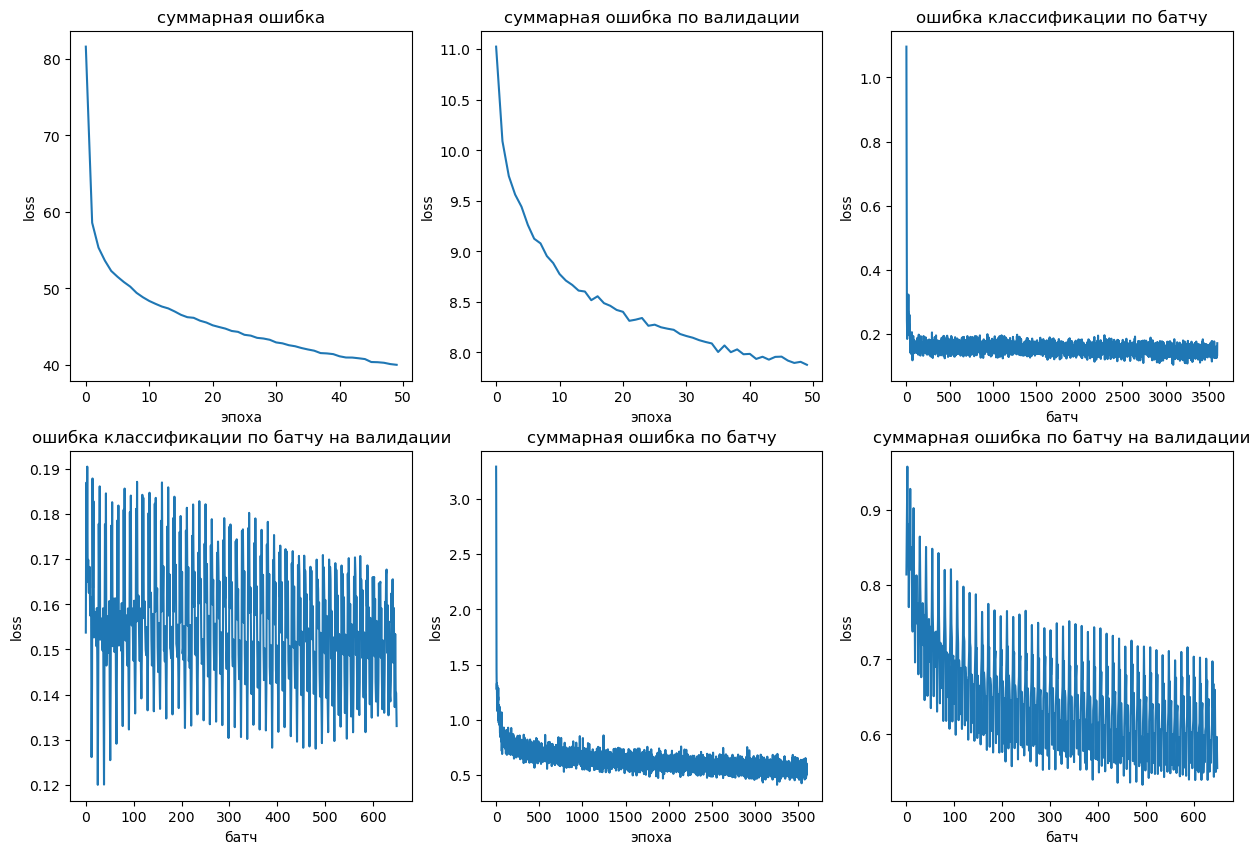

In [174]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].set_title('суммарная ошибка')
ax[0, 0].set_xlabel('эпоха')
ax[0, 0].set_ylabel('loss')
ax[0, 0].plot(train_loss)
ax[0, 1].set_title('суммарная ошибка по валидации')
ax[0, 1].set_xlabel('эпоха')
ax[0, 1].set_ylabel('loss')
ax[0, 1].plot(val_loss)
ax[0, 2].set_title('ошибка классификации по батчу')
ax[0, 2].set_xlabel('батч')
ax[0, 2].set_ylabel('loss')
ax[0, 2].plot(train_loss_history_class)
ax[1, 0].set_title('ошибка классификации по батчу на валидации')
ax[1, 0].set_xlabel('батч')
ax[1, 0].set_ylabel('loss')
ax[1, 0].plot(val_loss_history_class)
ax[1, 1].set_title('суммарная ошибка по батчу')
ax[1, 1].set_xlabel('эпоха')
ax[1, 1].set_ylabel('loss')
ax[1, 1].plot(train_loss_history)
ax[1, 2].set_title('суммарная ошибка по батчу на валидации')
ax[1, 2].set_xlabel('батч')
ax[1, 2].set_ylabel('loss')
ax[1, 2].plot(val_loss_history)

In [179]:
model.eval()
img = Image.open(os.path.join('im1', 'a090633c-360e-4363-bce9-52eac60ded90.jpg'))
transform = transforms.ToTensor()
ig = transform(img)
with torch.no_grad():
    pred = model([ig.to(device)])

In [180]:
pred

[{'boxes': tensor([[ 567.8444,  173.8934,  649.6987,  311.6897],
          [ 448.5406,  124.2227,  547.3051,  290.4136],
          [ 448.6551,   90.3608,  546.4877,  281.9751],
          [ 568.9988,  246.8469,  648.8124,  308.9203],
          [ 563.7763,  131.0018,  651.5469,  225.9611],
          [ 441.4975,   89.5944,  653.2120,  304.3237],
          [ 451.4674,  107.4122,  653.4901,  311.5744],
          [ 147.1774,  200.3677,  698.7195,  399.2146],
          [ 102.0627,  163.0042,  717.8497,  384.5898],
          [ 566.7282,  128.1685,  697.3232,  312.2581],
          [  93.5008, 1139.9337,  211.2409, 1358.4886],
          [  96.5686,  163.6208,  724.0021,  394.6534],
          [ 452.3129,   89.1915,  543.3552,  180.8917],
          [ 243.5879,   67.2338,  632.3992,  327.6822],
          [ 559.1819,  122.6585,  655.4366,  315.8018],
          [ 247.7212,   77.0879,  645.8298,  325.1184],
          [ 561.1594,  125.4325,  653.7100,  309.4749],
          [ 445.4630,   88.7677,  623.5

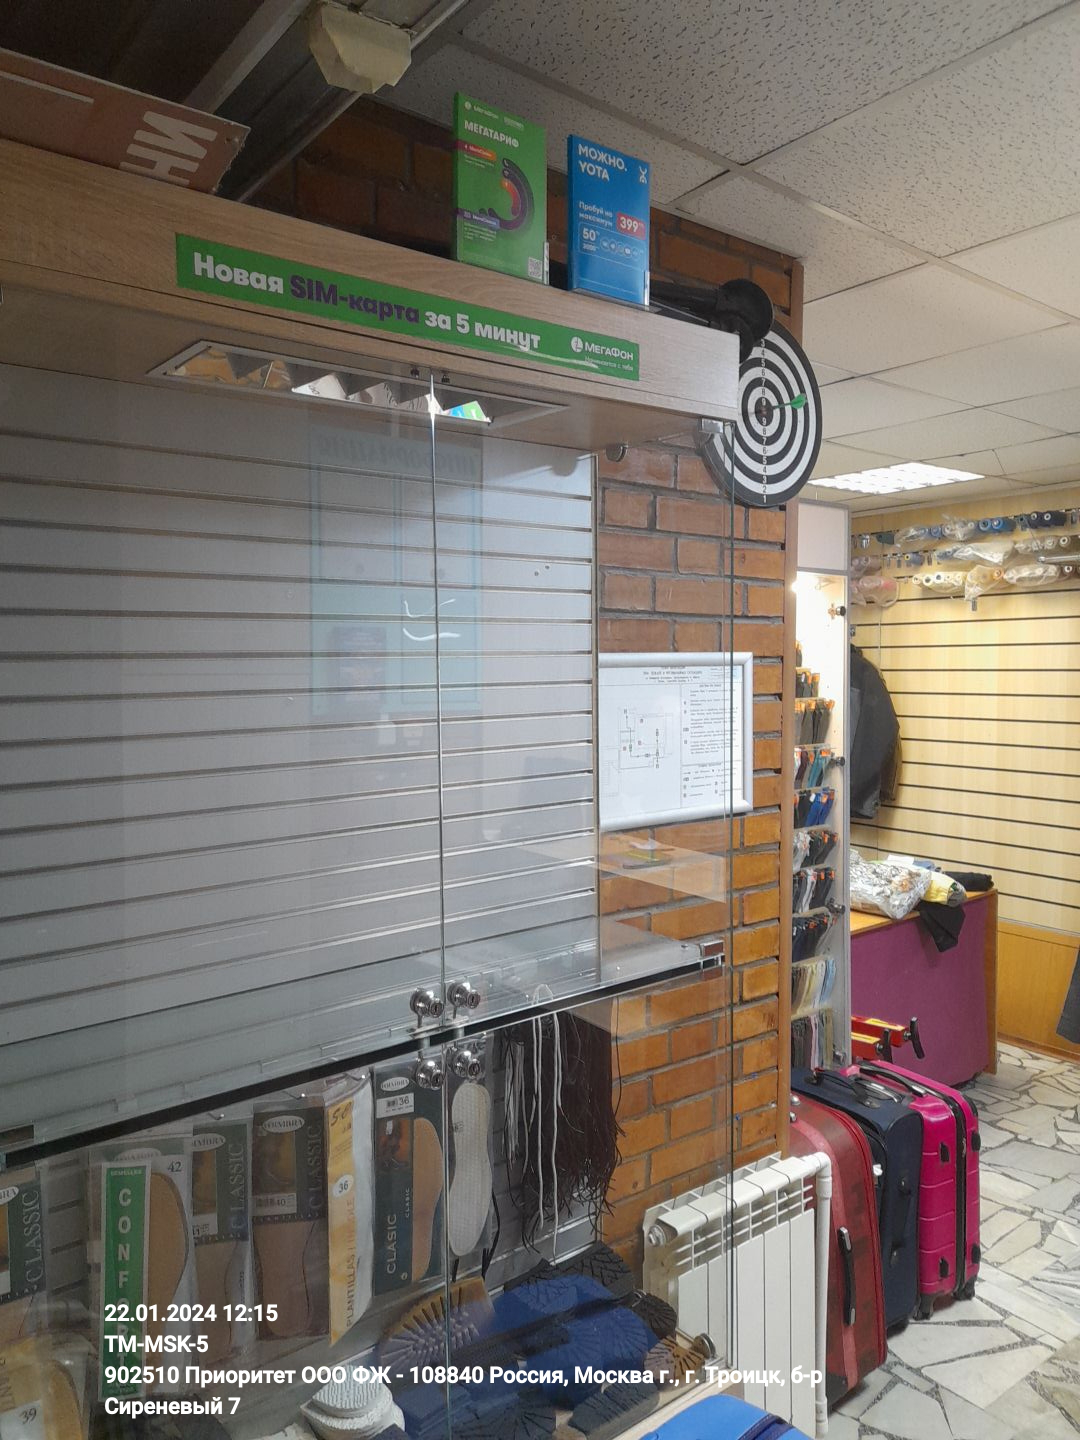

In [181]:
img

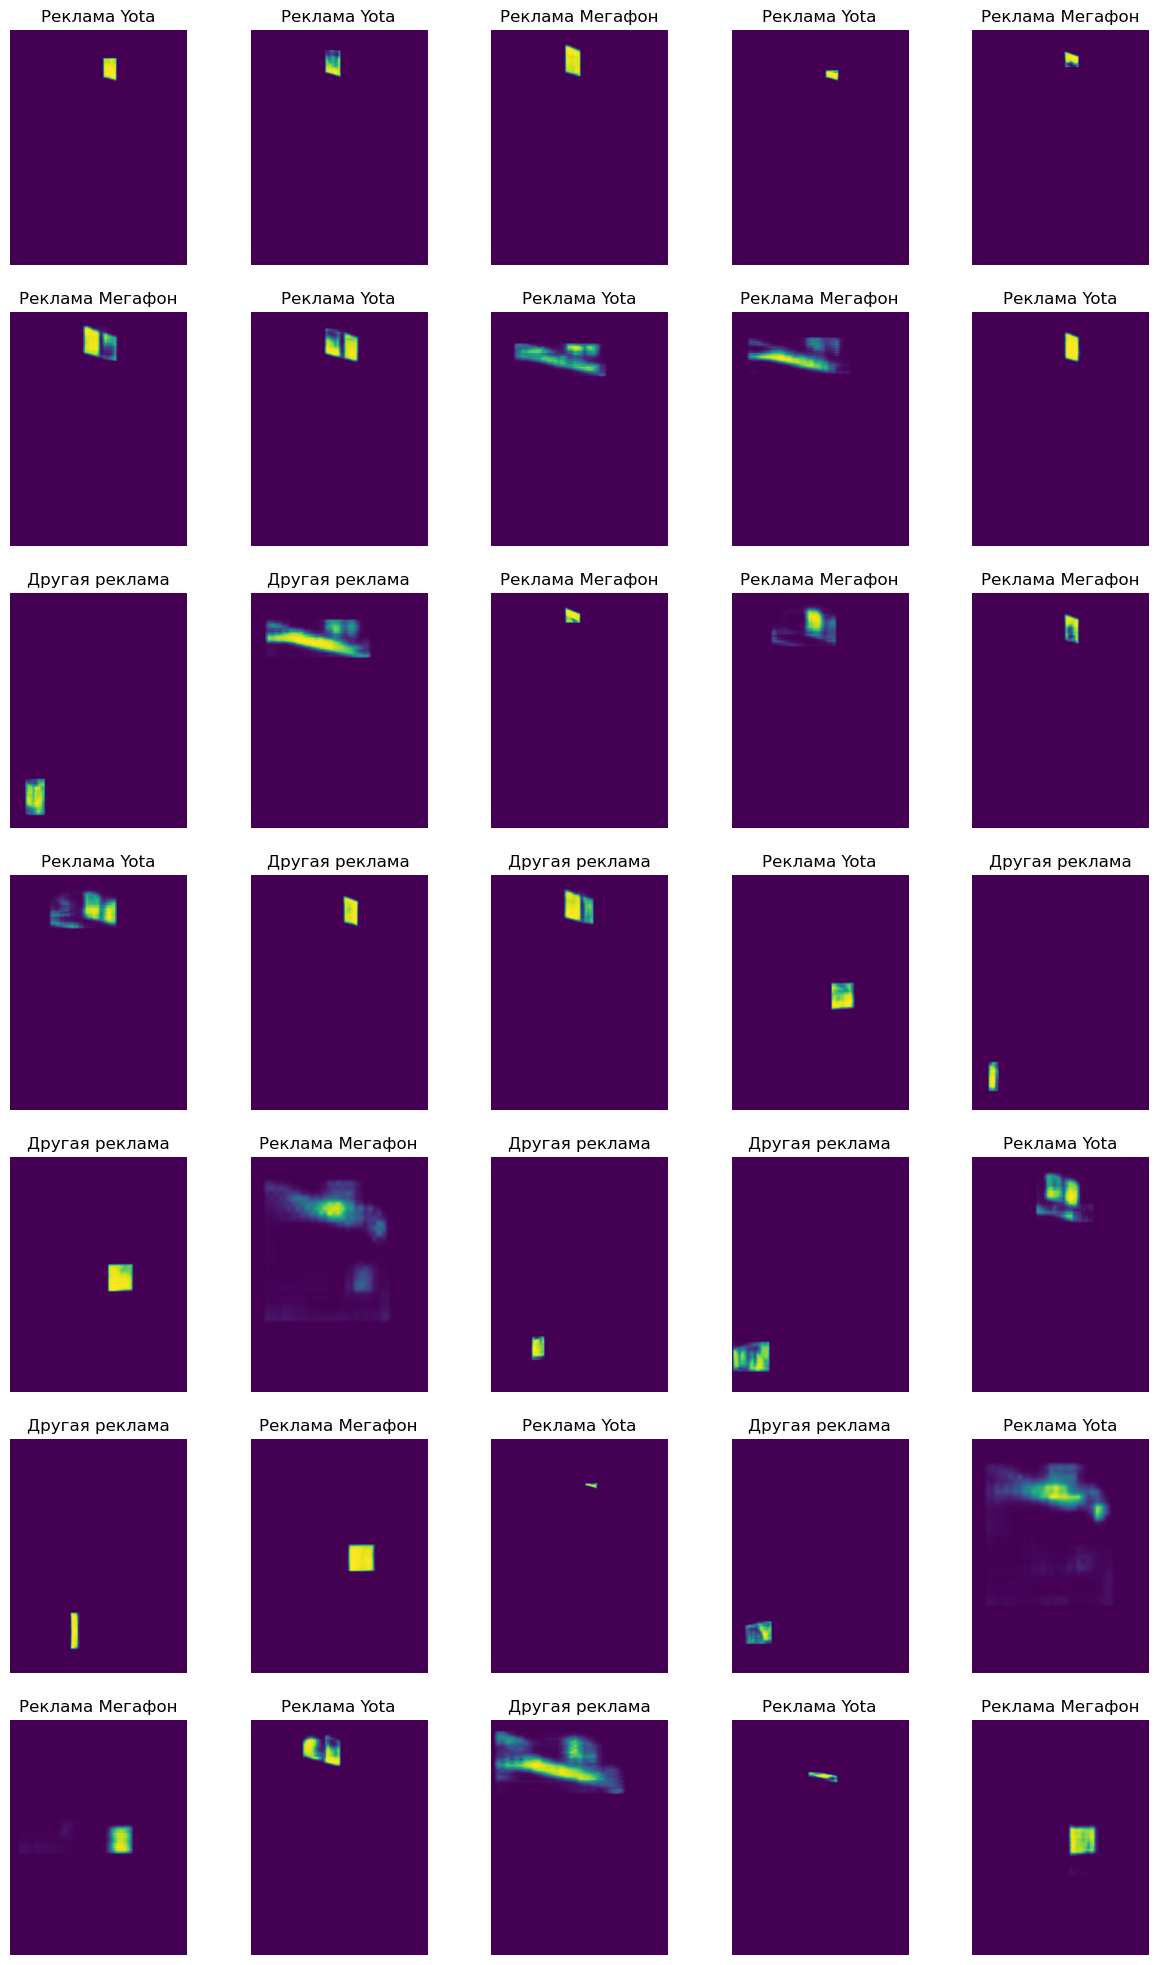

In [183]:
fig = plt.figure(figsize=(15, 25))
for i in range(len(pred[0]["labels"].cpu().detach().numpy())):
    ax = plt.subplot(7, 5, i + 1)
    prediction = pred[0]["labels"][i].cpu().detach().numpy()
    if prediction == 1:
        ax.set_title('Реклама Мегафон')
    elif prediction == 2:
        ax.set_title('Реклама Yota')
    elif prediction == 3:
        ax.set_title('Другая реклама')
    ax.axis('off')
    plt.imshow((pred[0]["masks"][i].cpu().detach().numpy() * 255).astype("uint8").squeeze())

In [184]:
torch.save(model.state_dict(), 'my_model.pth')